# 简单的DenseNet实现

与ResNet的不同之处在于，DenseNet是按照通道进行拼接而非相加。所以DenseNet的特征会增多，存在较高的过拟合的风险，需要增加一些正则化的手段，如Dropout。

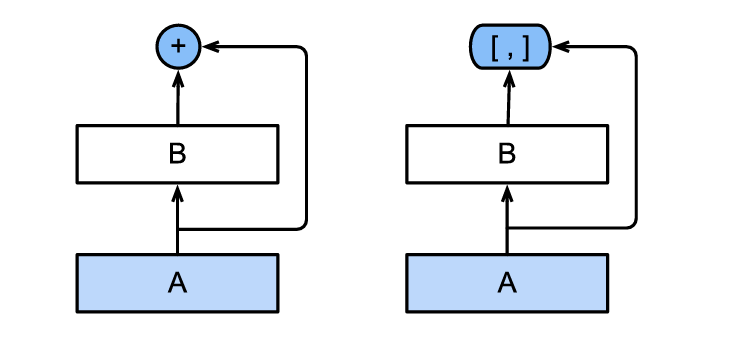

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self,in_planes,out_planes,dropRate):
        super().__init__()
        self.conv1=nn.Conv2d(in_planes,out_planes,3,1,1,bias=False)
        self.relu=nn.ReLU(inplace=True)
        self.bn1=nn.BatchNorm2d(out_planes)
        self.droprate=dropRate
    
    def forward(self,x):
        out=self.conv1(self.relu(self.bn1(x)))
        if self.droprate>0:
            out=F.dropout(out,p=self.droprate,training=self.training)
        return torch.cat([x,out],1)


In [2]:
#手动模拟随机丢失的代码
#随机丢失要求是一些元素被随机设置为0
#其余元素要放大（1/(1-drop_rate)
#缩放的目的是在训练和测试的时候保持输出的期望不变，数值稳定
def mannual_dropout(x,droprate,training=True):
    if droprate>0 and training:
        #保留随机数比droprate大的元素，则是true，然后变成1
        mask=(torch.rand_like(x)>droprate).float()
        #将mask乘x,实现随机丢失
        out=x*mask
        #进行缩放保证期望不变
        out=out/(1-droprate)
        print(f"掩码值:\n{mask}")
        print(f"drop后张量:\n{out}")
        print(f"缩放因子:{1/(1-droprate)}")
        return out
    else:
        return x
x=torch.tensor([[1.0, 2.0, 3.0, 4.0],
                  [5.0, 6.0, 7.0, 8.0]])
print(f"原始张量:\n{x}")
#应用随机丢失
drop_rate=0.5
print(f"随机丢失的概率:{drop_rate}")
out=mannual_dropout(x,drop_rate)


原始张量:
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])
随机丢失的概率:0.5
掩码值:
tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.]])
drop后张量:
tensor([[ 0.,  4.,  0.,  0.],
        [ 0.,  0., 14.,  0.]])
缩放因子:2.0


开始前归一化 vs 后归一化完整对比分析...

=== 训练对比实验 ===

训练过程对比:
Epoch 1: Pre-Act Loss = 0.985541, Post-Act Loss = 0.913742
Epoch 2: Pre-Act Loss = 1.104312, Post-Act Loss = 1.108353
Epoch 3: Pre-Act Loss = 0.963220, Post-Act Loss = 0.870559
Epoch 4: Pre-Act Loss = 0.979802, Post-Act Loss = 0.986989
Epoch 5: Pre-Act Loss = 1.123126, Post-Act Loss = 1.044805

最终结果:
前归一化最终损失: 1.123126
后归一化最终损失: 1.044805


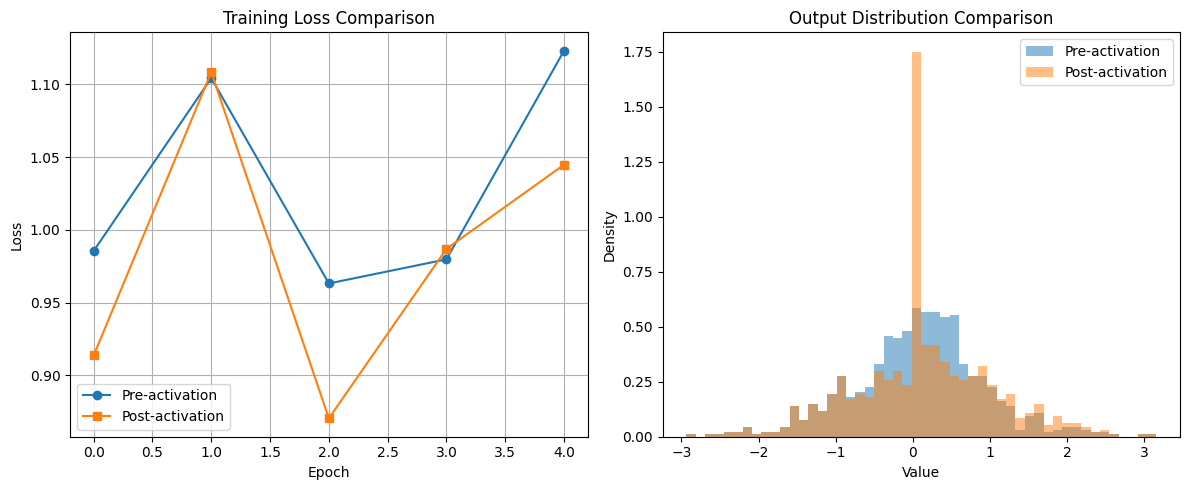


=== 总结 ===
前归一化平均损失: 1.031200
后归一化平均损失: 0.984890
✓ 后归一化在本实验中表现更好

前归一化优势:
- 梯度流动更好
- 训练更稳定
- 更适合密集连接

后归一化特点:
- 传统做法
- 概念更直观
- 在某些情况下也可能表现良好


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class DetailedComparison:
    """
    详细的前归一化和后归一化对比分析
    """
    
    def __init__(self):
        self.results = {}
    
    def create_models(self):
        """创建对比模型"""
        
        class PreActDenseBlock(nn.Module):
            def __init__(self, in_channels, growth_rate):
                super().__init__()
                self.bn = nn.BatchNorm2d(in_channels)
                self.relu = nn.ReLU(inplace=True)
                self.conv = nn.Conv2d(in_channels, growth_rate, 3, padding=1, bias=False)
            
            def forward(self, x):
                out = self.bn(x)
                out = self.relu(out)
                out = self.conv(out)
                return torch.cat([x, out], 1)
        
        class PostActDenseBlock(nn.Module):
            def __init__(self, in_channels, growth_rate):
                super().__init__()
                self.conv = nn.Conv2d(in_channels, growth_rate, 3, padding=1, bias=False)
                self.bn = nn.BatchNorm2d(growth_rate)
                self.relu = nn.ReLU(inplace=True)
            
            def forward(self, x):
                new_features = self.conv(x)
                new_features = self.bn(new_features)
                new_features = self.relu(new_features)
                return torch.cat([x, new_features], 1)
        
        return PreActDenseBlock, PostActDenseBlock
    
    def train_comparison(self, epochs=5):
        """训练对比"""
        print("=== 训练对比实验 ===\n")
        
        PreActBlock, PostActBlock = self.create_models()
        
        # 创建模型
        pre_model = PreActBlock(8, 4)  # 8输入，4增长率
        post_model = PostActBlock(8, 4)  # 8输入，4增长率
        
        # 创建数据
        #randn是生成符合正态分布的随机数
        #randint是在范围内的随机整数
        data = torch.randn(16, 8, 16, 16)
        targets = torch.randint(0, 2, (16,))  # 简单二分类
        
        # 损失函数
        criterion = nn.MSELoss()
        
        # 优化器
        pre_optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.01)
        post_optimizer = torch.optim.Adam(post_model.parameters(), lr=0.01)
        
        pre_losses = []
        post_losses = []
        
        print("训练过程对比:")
        
        for epoch in range(epochs):
            # 前归一化训练
            pre_optimizer.zero_grad()
            pre_output = pre_model(data.clone())
            pre_loss = criterion(pre_output.mean(dim=[2, 3]), torch.randn(16, pre_output.shape[1]))
            pre_loss.backward()
            pre_optimizer.step()
            
            # 后归一化训练``
            post_optimizer.zero_grad()
            post_output = post_model(data.clone())
            post_loss = criterion(post_output.mean(dim=[2, 3]), torch.randn(16, post_output.shape[1]))
            post_loss.backward()
            post_optimizer.step()
            
            pre_losses.append(pre_loss.item())
            post_losses.append(post_loss.item())
            
            print(f"Epoch {epoch+1}: Pre-Act Loss = {pre_loss.item():.6f}, "
                  f"Post-Act Loss = {post_loss.item():.6f}")
        
        return pre_losses, post_losses
    
    def visualize_results(self, pre_losses, post_losses):
        """可视化结果"""
        plt.figure(figsize=(12, 5))
        
        # 损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(pre_losses, label='Pre-activation', marker='o')
        plt.plot(post_losses, label='Post-activation', marker='s')
        plt.title('Training Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # 输出分布对比
        plt.subplot(1, 2, 2)
        
        # 生成示例输出
        PreActBlock, PostActBlock = self.create_models()
        sample_input = torch.randn(1, 8, 8, 8)
        
        with torch.no_grad():
            pre_output = PreActBlock(8, 4)(sample_input)
            post_output = PostActBlock(8, 4)(sample_input)
        
        plt.hist(pre_output.flatten().numpy(), bins=50, alpha=0.5, label='Pre-activation', density=True)
        plt.hist(post_output.flatten().numpy(), bins=50, alpha=0.5, label='Post-activation', density=True)
        plt.title('Output Distribution Comparison')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def run_full_analysis(self):
        """运行完整分析"""
        print("开始前归一化 vs 后归一化完整对比分析...\n")
        
        # 训练对比
        pre_losses, post_losses = self.train_comparison()
        
        print(f"\n最终结果:")
        print(f"前归一化最终损失: {pre_losses[-1]:.6f}")
        print(f"后归一化最终损失: {post_losses[-1]:.6f}")
        
        # 可视化
        self.visualize_results(pre_losses, post_losses)
        
        # 总结
        print(f"\n=== 总结 ===")
        print(f"前归一化平均损失: {np.mean(pre_losses):.6f}")
        print(f"后归一化平均损失: {np.mean(post_losses):.6f}")
        
        if np.mean(pre_losses) < np.mean(post_losses):
            print("✓ 前归一化在本实验中表现更好")
        else:
            print("✓ 后归一化在本实验中表现更好")
        
        print(f"\n前归一化优势:")
        print("- 梯度流动更好")
        print("- 训练更稳定")
        print("- 更适合密集连接")
        
        print(f"\n后归一化特点:")
        print("- 传统做法")
        print("- 概念更直观")
        print("- 在某些情况下也可能表现良好")

# 运行完整分析
comparator = DetailedComparison()
comparator.run_full_analysis()

## 类似ResNet，DenseNet为了减小计算量也有一个 Bottleneck 结构

DenseNet对于图像的下采样不是在Bottleneck中进行的，而是在每个Block的最后进行的。
有专门的Transition块来进行下采样

In [4]:
class Bottleneck(nn.Module):
    expension=4
    def __init__(self,in_channels,out_channels,dropout_prob=0.2):
        super().__init__()
        #使用前归一化
        inter_channels=in_channels//expension
        self.norm1=nn.BatchNorm2d(in_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv1=nn.Conv2d(in_channels,inter_channels,kernel_size=1,stride=0,bias=False)

        self.norm2=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(inter_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
    
    def forward(self,x):
        identity=x
        out=self.conv1(self.relu(self.norm1(x)))
        out=self.conv2(self.relu(self.norm2(out)))
        out =torch.cat([identity,out],dim=1)
        return out

In [5]:
#负责下采样的层
class Transition(nn.Module):
    def __init__(self,in_channels,out_channels,dropRate=0.0):
        super().__init__()
        self.norm1=nn.BatchNorm2d(in_channels)
        self.relu=nn.ReLU(inplace=True)
        self.dropout_path=dropRate
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False)
        self.pool1=nn.AvgPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        out=self.conv1(self.relu(self.norm1(x)))
        if self.dropout_path is not None:
            out=F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out=self.pool1(out)
        return out


In [6]:
class DenseBlock(nn.Module):
    def __init__(self,nb_layers,in_planes,growth_rate,block,dropRate=0.0):
        super(DenseBlock,self).__init__()
        self.layer=self._make_layer(block,in_planes,growth_rate,nb_layers,dropRate)
    
    def _make_layer(self,block,in_planes,growth_rate,nb_layers,dropRate):
        layers=[]
        for i in range(int(nb_layers)):
            layers.append(block(i,in_planes+i*growth_rate,growth_rate,dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [ ]:
class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super().__init__()
        #首先根据depth计算DenseBlock的层数
        in_planes = 2 * growth_rate
        #开头一个卷积层，2个transition层，最后一个FC层。所以-4
        n=(depth-4)/3

        